In [1]:
using POMDPModels: SimpleGridWorld
import POMDPTools # for a more fully-functional render
using POMDPTools: FunctionPolicy
using LinearAlgebra: I
import CommonRLInterface as RL
using CommonRLInterface: actions, act!, observe, reset!, AbstractEnv, observations, terminated, render
using SparseArrays

# Interacting with CommonRLInterface Environments

In [2]:
env = convert(AbstractEnv, SimpleGridWorld())

POMDPTools.CommonRLIntegration.MDPCommonRLEnv{AbstractArray, SimpleGridWorld, StaticArraysCore.SVector{2, Int64}}(SimpleGridWorld
  size: Tuple{Int64, Int64}
  rewards: Dict{StaticArraysCore.SVector{2, Int64}, Float64}
  terminate_from: Set{StaticArraysCore.SVector{2, Int64}}
  tprob: Float64 0.7
  discount: Float64 0.95
, [7, 10])

In [3]:
# define a more fully featured render specifically for this problem
RL.render(env::POMDPTools.MDPCommonRLEnv{<:Any, SimpleGridWorld, <:Any}; kwargs...) = POMDPTools.render(env.m, (s=env.s,); kwargs...)

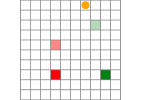

In [4]:
render(env)

In [5]:
actions(env)

(:up, :down, :left, :right)

In [6]:
act!(env, :up) # returns reward

0.0

In [7]:
observe(env)

2-element StaticArraysCore.SVector{2, Int64} with indices SOneTo(2):
  7
 10

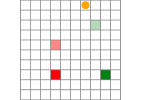

In [8]:
render(env)

In [9]:
terminated(env)

false

In [10]:
reset!(env)

In [11]:
observe(env)

2-element StaticArraysCore.SVector{2, Int64} with indices SOneTo(2):
 4
 7

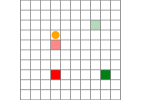

In [12]:
render(env)

In [13]:
function simulate!(env::AbstractEnv, policy::Function)
    reset!(env)
    s = observe(env)
    hist = []
    while !terminated(env)
        a = policy(s)
        r = act!(env, a)
        sp = observe(env)
        push!(hist, (s=s, a=a, r=r, sp=sp))
        s = sp
    end
    return hist
end

simulate! (generic function with 1 method)

In [14]:
simulate!(env, s->rand(actions(env)))

12-element Vector{Any}:
 (s = [8, 5], a = :right, r = 0.0, sp = [8, 6])
 (s = [8, 6], a = :right, r = 0.0, sp = [9, 6])
 (s = [9, 6], a = :up, r = 0.0, sp = [9, 7])
 (s = [9, 7], a = :up, r = 0.0, sp = [9, 6])
 (s = [9, 6], a = :down, r = 0.0, sp = [9, 5])
 (s = [9, 5], a = :left, r = 0.0, sp = [8, 5])
 (s = [8, 5], a = :down, r = 0.0, sp = [8, 4])
 (s = [8, 4], a = :left, r = 0.0, sp = [9, 4])
 (s = [9, 4], a = :left, r = 0.0, sp = [8, 4])
 (s = [8, 4], a = :down, r = 0.0, sp = [8, 3])
 (s = [8, 3], a = :right, r = 0.0, sp = [9, 3])
 (s = [9, 3], a = :left, r = 10.0, sp = [-1, -1])

# Maximum Likelihood Model-Based RL

(With updates after every episode)

In [15]:
function max_likelihood_model_based_rl_episode!(N, ρ, env, index; ϵ=0.10, γ=0.9)
    
    # calculate MDP model
    A = collect(actions(env))
    sz = length(index) # number of states
    sums = Dict(a => sum(N[a], dims=2).+1e-6 for a in A)
    T = Dict(a => N[a]./sums[a] for a in A)
    R = Dict(a => ρ[a]./sums[a] for a in A)
    
    # solve with VI
    V = zeros(sz)
    oldV = ones(sz)
    
    while maximum(abs, V-oldV) > 0.0001
        oldV[:] = V
        V[:] = max.((R[a] .+ γ*T[a]*V for a in A)...)
    end
    
    Q = Dict(a => R[a] .+ γ*T[a]*V for a in A)
    
    policy(s) = A[argmax([Q[a][index[s]] for a in A])]
    
    # setup
    s = observe(env)
    hist = [s]
    
    while !terminated(env)
        if rand() < ϵ
            a = rand(actions(env))
        else
            a = policy(observe(env))
        end
        
        r = act!(env, a)
        sp = observe(env)
        push!(hist, sp)
        N[a][index[s], index[sp]] += 1
        ρ[a][index[s]] += r
        s = sp
    end
    
    return (;hist, V, policy)
end

max_likelihood_model_based_rl_episode! (generic function with 1 method)

In [16]:
function max_likelihood_model_based_rl!(env; n_episodes=100, ϵ=0.10, γ=0.9)
    sz = length(observations(env))
    n = Dict(a => spzeros(sz, sz) for a in actions(env))
    ρ = Dict(a => spzeros(sz) for a in actions(env))
    index = Dict(s => i for (i, s) in enumerate(observations(env)))
    episodes = []
    
    for i in 1:n_episodes
        reset!(env)
        push!(episodes, max_likelihood_model_based_rl_episode!(n, ρ, env, index; ϵ=max(0.1, 1-i/n_episodes)))
    end
    return episodes, index
end

max_likelihood_model_based_rl! (generic function with 1 method)

In [17]:
using Interact

WebIO._IJuliaInit()

In [18]:
n_episodes = 100
tprob = 0.9
m = SimpleGridWorld(tprob=tprob)
env = convert(AbstractEnv, m)
episodes, index = max_likelihood_model_based_rl!(env, n_episodes=n_episodes);

In [19]:
@manipulate for episode in 1:length(episodes), step in 1:maximum(ep->length(ep.hist), episodes)
    ep = episodes[episode]
    i = min(step, length(ep.hist))
    POMDPTools.render(m, (s=ep.hist[i],), color=s->ep.V[index[s]], policy=FunctionPolicy(ep.policy))
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["episode"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 100, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(50), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/zach/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/zach/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/zach/.julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), Asset("css", nothing, "/home/zach/.julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), Asset("css", nothing, "/home/zach/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f4e05f076b0, Task (runnable) @0x00007f4e05f076b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"38\",\"39\",\"40\",\"41\",\"42\",\"43\",\"44\",\"45\",\"46\",\"47\",\"48\",\"49\",\"50\",\"51\",\"52

In [43]:
    ep = episodes[episode]
    i = min(step, length(ep.hist))
    POMDPTools.render(m, (s=ep.hist[i],), color=s->ep.V[index[s]], policy=FunctionPolicy(ep.policy))

LoadError: ArgumentError: invalid index: Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["episode"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 100, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(50), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/zach/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/zach/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/zach/.julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), Asset("css", nothing, "/home/zach/.julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), Asset("css", nothing, "/home/zach/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007ffb7e5a6400, Task (runnable) @0x00007ffb7e5a6400), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"38\",\"39\",\"40\",\"41\",\"42\",\"43\",\"44\",\"45\",\"46\",\"47\",\"48\",\"49\",\"50\",\"51\",\"52\",\"53\",\"54\",\"55\",\"56\",\"57\",\"58\",\"59\",\"60\",\"61\",\"62\",\"63\",\"64\",\"65\",\"66\",\"67\",\"68\",\"69\",\"70\",\"71\",\"72\",\"73\",\"74\",\"75\",\"76\",\"77\",\"78\",\"79\",\"80\",\"81\",\"82\",\"83\",\"84\",\"85\",\"86\",\"87\",\"88\",\"89\",\"90\",\"91\",\"92\",\"93\",\"94\",\"95\",\"96\",\"97\",\"98\",\"99\",\"100\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"3210418039061984427\",\"id\":\"16036105927751927581\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"3210418039061984427\",\"id\":\"1335440073036531470\",\"type\":\"observable\"})};\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        [this[\"formatted_val\"]=ko.computed(    function(){\n        return this.formatted_vals()[parseInt(this.index())-(1)];\n    }\n,this)]\n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"3210418039061984427\",\"id\":\"16036105927751927581\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"index\"].subscribe((function (val){!(this.valueFromJulia[\"index\"]) ? (WebIO.setval({\"name\":\"index\",\"scope\":\"3210418039061984427\",\"id\":\"1335440073036531470\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"index\"]=false}),self)]\n        \n    }\n    self.model = new AppViewModel();\n    self.valueFromJulia = {};\n    for (var key in json_data) {\n        self.valueFromJulia[key] = false;\n    }\n    ko.applyBindings(self.model, self.dom);\n}\n);\n    (WebIO.importBlock({\"data\":[{\"name\":\"knockout\",\"type\":\"js\",\"url\":\"/assetserver/c59f1a69f8f37ac95e719c439185f863392fe7fb-knockout.js\"},{\"name\":\"knockout_punches\",\"type\":\"js\",\"url\":\"/assetserver/4b8230598c2e79832ee2b8f9f54be76bd0bd94aa-knockout_punches.js\"}],\"type\":\"async_block\"})).then((imports) => handler.apply(this, imports));\n}\n")])], Dict{Symbol, Any}(:className => "field interact-widget")) of type Widget{:slider, Int64}